# A very simple pipeline to convert SAC to WAV files 

ATTENTION 1: 
It you have a "%%capture" at the top of the cell no output will be shown. If you are suspicious that something is going terribly wrong you can comment out this line and see the whole output.

ATTENTION 2:
Basemap is deprecated in favor of the Cartopy project. 

## Import 

You usually do not change this part.

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import os
import sys
import time
import glob
from IPython import display

from soundfile import SoundFile
from natsort import natsorted

import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
from obspy import read, Trace
from obspy.signal.tf_misfit import plot_tfr

# the file src_sac2wav contains written functions for exporting sac to wav files
from src_sac2wav import *

## Download the data

<img src="DMT_logo.png" width="200" align="center">

### Input for Download

Please read the comments for an explaination of the settings.

In [15]:
# Your output path where your downloads and process is saved
save_path = '/mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20.10.2021_continuous'

# Choose between "event" and "continuous" or "day" mode.
# When you are choosing "continuous" or "day" mode, day files will be downloaded regardless of the mode. 
# In continuous mode the day files are later merged to one long trace and exported as WAV. 
mode = 'continuous'

# If set to "False" the code does not download anything but gives you a table of available 
# events in the timespan you define in start_time/end_time
event_info = False

start_time = '2013-05-28'
end_time = '2013-06-01'

# "preset" and "offset" make only sense in event mode, this will not be used in continuous or day mode!
preset = None  # in [SEC] default: 0; put None if you want to use default values
offset = 0  # default: 1800 for event-based mode and 0 for continuous mode

min_mag = '8.0'
max_mag = '10'

samplingrate = None  # or None 
waveform_format = 'sac'  # or mseed 

event_catalog = 'NEIC_USGS' # you can change that, for more information check out obspyDMT
data_source = 'RESIF'  # all or RESIF, IRIS, etc. check out obspyDMT for more information

network = 'YV'  # you can also use '*' for all available notworks or stations. Attention, you might download a lot of data
station = 'RR47'
channel = '*'

# ATTENTION!!! If this is set to TRUE and the datapath is found, delete it before running obspyDMT
reset = True

# parallel request is on default with 4 cores 
parallel_request = True

# parallel processing is on default with 4 cores
parallel_process = True

# instrument response, yes/no
instrument_correction = False

# process_unit that you want to use:
process_unit = 'process_unit_wav'
# Apply a bandpass filter to the seismograms before deconvolution, syntax: 'None' or '(f1,f2,f3,f4)' 
# which are the four corner frequencies of a cosine taper, default: '(0.008, 0.012, 3.0, 4.0)'.
# pre_filt = '(0.008, 0.012, 3.0, 4.0)'  # or False for default/ None for none
pre_filt = False


In [23]:
# output paths will be generated:
wav_save, save_fig_path = generate_output_folders(mode, save_path)

Generate the obspyDMT command first:

In [17]:
# here the input from above is put together for obspyDMT 
execute_DMT = generate_output_command(save_path, mode, event_info, start_time, end_time, preset, offset, min_mag, max_mag,
                                     samplingrate, waveform_format, event_catalog, data_source, network, station, channel,
                                     reset, parallel_request, parallel_process, instrument_correction, process_unit, pre_filt)

print(f'Executing following command in the next cell:\n\n{execute_DMT}')

Executing following command in the next cell:

obspyDMT --datapath /mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20.10.2021_continuous --min_date 2013-05-28 --max_date 2013-06-01 --waveform_format sac --data_source RESIF --pre_process process_unit_wav --continuous  --sta RR47 --net YV --req_parallel --req_np 10 --parallel_process --process_np 10  --reset


Attention! Only execute the next line if you want to download or update your dataset. If you just want to plot or export some specific data you already downloaded then you do not have to execute the next line!

You can also c+p the command in a terminal if you do not want to do it in the notebook.

In [18]:
!{execute_DMT}

/mnt/store/mariat/anaconda3/envs/py37/lib/python3.7/site-packages/obspy/clients/arclink/__init__.py:178: ObsPyDeprecationWarning: The ArcLink protocol will be deprecated in the near future. Please, use the client contacting the routing service provided by EIDA: https://docs.obspy.org/packages/obspy.clients.fdsn.html#basic-routing-clients-usage
  warnings.warn(msg, category=ObsPyDeprecationWarning)
--------------------------------------------------------------------------------
		   obspyDMT (obspy Data Management Tool)

	Python Toolbox for Retrieving, Processing and Management of
			Large Seismological Datasets

:copyright:
The ObsPy Development Team (devs@obspy.org)

Developed by Kasra Hosseini
email: kasra.hosseinizad@earth.ox.ac.uk

:license:
GNU General Public License, Version 3
(http://www.gnu.org/licenses/gpl-3.0-standalone.html)
--------------------------------------------------------------------------------


Remove the following directory:
/mnt/seismodata2/MT/_OUTPUT_/test_sac

In case your download was interrupted and **raw** files were not converted to **processed**, execute this next cell. Otherwise, please skip.

In [14]:
proc_DMT = f'{execute_DMT} --local'
!{proc_DMT}

/mnt/store/mariat/anaconda3/envs/py37/lib/python3.7/site-packages/obspy/clients/arclink/__init__.py:178: ObsPyDeprecationWarning: The ArcLink protocol will be deprecated in the near future. Please, use the client contacting the routing service provided by EIDA: https://docs.obspy.org/packages/obspy.clients.fdsn.html#basic-routing-clients-usage
  warnings.warn(msg, category=ObsPyDeprecationWarning)
--------------------------------------------------------------------------------
		   obspyDMT (obspy Data Management Tool)

	Python Toolbox for Retrieving, Processing and Management of
			Large Seismological Datasets

:copyright:
The ObsPy Development Team (devs@obspy.org)

Developed by Kasra Hosseini
email: kasra.hosseinizad@earth.ox.ac.uk

:license:
GNU General Public License, Version 3
(http://www.gnu.org/licenses/gpl-3.0-standalone.html)
--------------------------------------------------------------------------------


obspyDMT primary mode: local


use the local files:
/mnt/seismodata2/

## Access downloaded data and save as WAV files

### Reading station information

No visible output generated with %%caputre.

Attnetnion: In some cases there might be a gap in data and the %%capture suppress the Warning messages! If you want to see them then comment the first line of the next cell.

In [19]:
%%capture
# find read_station_information function in src_sac2wav.py if you want to know what is happening inside this function
df_all = read_station_information(save_path, '*')
# you can change the '*' to a specific event, but this wildcard will give you everything 
# a data frame (df) is generated with all station event information for your current download

Here, you can look at the data frame:

In [20]:
print(df_all)

   net station location channel    stalat   stalon   staele None   cata  \
0   YV    RR47       00     BDH  -27.6958  65.7553  -4582.0  0.0  RESIF   
1   YV    RR47       00     BH1  -27.6958  65.7553  -4582.0  0.0  RESIF   
2   YV    RR47       00     BH2  -27.6958  65.7553  -4582.0  0.0  RESIF   
3   YV    RR47       00     BHZ  -27.6958  65.7553  -4582.0  0.0  RESIF   
4   YV    RR47       00     BDH  -27.6958  65.7553  -4582.0  0.0  RESIF   
5   YV    RR47       00     BH1  -27.6958  65.7553  -4582.0  0.0  RESIF   
6   YV    RR47       00     BH2  -27.6958  65.7553  -4582.0  0.0  RESIF   
7   YV    RR47       00     BHZ  -27.6958  65.7553  -4582.0  0.0  RESIF   
8   YV    RR47       00     BDH  -27.6958  65.7553  -4582.0  0.0  RESIF   
9   YV    RR47       00     BH1  -27.6958  65.7553  -4582.0  0.0  RESIF   
10  YV    RR47       00     BH2  -27.6958  65.7553  -4582.0  0.0  RESIF   
11  YV    RR47       00     BHZ  -27.6958  65.7553  -4582.0  0.0  RESIF   
12  YV    RR47       00  

## Plot station event distribution

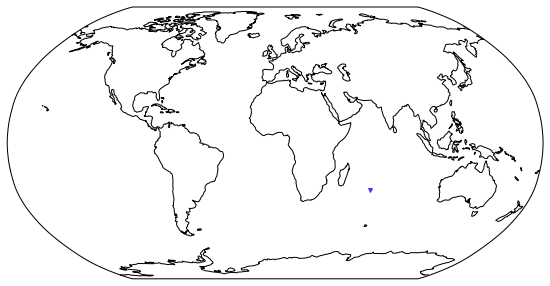

In [24]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
# ax.stock_img()
ax.coastlines()

df1 = df_all.drop_duplicates(['stalon','stalat'])
ax.scatter(df1['stalon'].astype(float), df1['stalat'].astype(float), c='b', marker='v', s=15, alpha=0.7,  transform=ccrs.PlateCarree())

if mode == 'event':
    df2 = df_all.drop_duplicates(['evlon','evlat'])
    ax.scatter(df2['evlon'].astype(float), df2['evlat'].astype(float), c='r', marker='*', s=65, alpha=0.7, transform=ccrs.PlateCarree())

# always save this plot
plt.savefig(os.path.join(save_fig_path, 'station_event_map.png'), dpi=300)
plt.show()

### Creating Poly-WAV's

Seperate WAV files are automatically written when data is downloaded. When exporting poly-WAV files and Hydrophone channel is not present for landstation a zero trace is created and exportet instead.

Even if you can download all possible channels (e.g. Water current, temperature, etc... see also here: https://ds.iris.edu/ds/nodes/dmc/tools/data_channels/#VOC) only seismometer channels are exported to WAV files. Only channels starting with:

    XX E       Extremely Short Period  ≥ 80 to < 250< 10 sec
    XX S       Short Period  ≥ 10 to < 80< 10 sec
    
    H       High Broad Band ≥ 80 to < 250≥ 10 sec
    B       Broad Band≥ 10 to < 80≥ 10 sec
    M       Mid Period> 1 to < 10LLong Period≈ 1
    L	    Long Period	≈ 1
    V       Very Long Period≈ 0.1
    
    XX U       Ultra Long Period≈ 0.01
    XX R       Extremely Long Period≥ 0.0001 to < 0.001

will be considered for converting for WAV files. There are even longer/shorter period channels which can be added at a later stage if desired.

For instance

    VOC measures water current
    VKI measures inside Temperature
and

    the “LOG” channel for the console log
    the “SOH” channel for the main state of health channel

are skipped. 

**Note!** framerate and bitrate are set to 48000 and PCM_24 when downloaded for the single WAV files. You can change that for the poly files. If you want to change it for the single files you have to change it in **process_unit_wav.py** at the bottom of the file (don't forget to save your changes!). 

**Attention!** you are setting the mode (event, continous, day) on top of the notebook. Here, you can define another folder to process if you wish. Default is to use the above settings.

### There can be several processed folders depending on your above input

'processed': [yes] 'sampling_rate' and [yes] 'instrument_correction'

'resamp' : [yes] 'sampling_rate' and [no] 'instrument_correction'

'instr': [no] 'sampling_rate' and [yes] 'instrument_correction'

'noinstr_noresamp': [no] 'sampling_rate' and [no] 'instrument_correction'

In [25]:
# ================
# SAC to WAV input 
# ================

# this is the path of the above downloaded data, but you can also put a path to other previously downloaded data
dmt_folder = save_path

# this is the mode from above or adjust to something else you already downloaded
wav_mode = 'continuous'

# which folder you want to confert to poly wavs
# put one of these four options:
# 'processed', 'resamp', 'instr', 'noinstr_noresamp'
folder_to_process = 'noinstr_noresamp'

# if poly_wav files should be generated. (I left this flag but theoretically if 
# you do not want poly files you already have the single files from the obspyDMT download.)
poly_wav = True

# What and how much to process depending on the wav_mode/mode
proc_wavs_events = ['20210729_061549.a']  # or ['*_*.*'] 
proc_wavs_days = [start_time, 3]  # or for days '*'

# read: start_date | how many days after startdate | how many waveforms/chunks      
proc_wavs_continuous = [start_time, '*' , 3]  # or for days '*' | start_time can also be in this format 'YYYY-MM-DD'

station_selection = '*'  # or "RR05" or '*' or ['PL08', 'BIG2']
channel_selection = '*' # please just give the first letter of the channel you want, eg. B, H, L ...

# WAV settings
framerate = 48000
bitrate = 'PCM_24'

# Normalisation factor
norm = -9 # or '-9' for chunk wise normalisation

# generates automatically plots of SAC files in WAV folder
plot_waveforms = True

# just in case the paths do not exist yet
wav_save, save_fig_path = generate_output_folders(wav_mode, dmt_folder)

The below output shows you the maximum amplitude of each trace for your selected settings. This usually helps you to play around with the normalisation factor of the traces. Default is "norm = -9", the maximum amplitude of all traces is used for normalisation. Whereas if you give a value, e.g. "norm = 59673.0", all traces will be normalised based on that value.

The next cell doesn't do anything except giving you the amplitudes and does not need to be executed every time.

In [30]:
all_paths = get_proc_paths(folder_to_process, dmt_folder, wav_mode, station_selection, channel_selection)

collect_max = []

for i, path in enumerate(all_paths):
    tr = read(path)[0]
    maxtr = np.max(abs(tr.data))
    print(f'{i:05d} | {path} | {tr.id} | {tr.stats.npts} | {maxtr}')
    collect_max.append(maxtr)

print(f'Max amplitude of all channels: {max(collect_max)}')

00000 | /mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20.10.2021_continuous/continuous1/proc_noinstr_noresamp/YV.RR47.00.BDH | YV.RR47.00.BDH | 8640001 | 59673.0
00001 | /mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20.10.2021_continuous/continuous1/proc_noinstr_noresamp/YV.RR47.00.BH1 | YV.RR47.00.BH1 | 8640001 | 45434.0
00002 | /mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20.10.2021_continuous/continuous1/proc_noinstr_noresamp/YV.RR47.00.BH2 | YV.RR47.00.BH2 | 8640001 | 55544.0
00003 | /mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20.10.2021_continuous/continuous1/proc_noinstr_noresamp/YV.RR47.00.BHZ | YV.RR47.00.BHZ | 8640001 | 55257.0
00004 | /mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20.10.2021_continuous/continuous2/proc_noinstr_noresamp/YV.RR47.00.BDH | YV.RR47.00.BDH | 8640001 | 50017.0
00005 | /mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20.10.2021_continuous/continuous2/proc_noinstr_noresamp/YV.RR47.00.BH1 | YV.RR47.00.BH1 | 8640001 | 34923.0
00006 | /mnt/seismodata2/MT/_OUTPUT_/test_sac2wav_20

In [31]:
# %%capture
stars = '*'*len('Mode: ' + wav_mode)
print(f'{stars}')
print(f'Mode: {wav_mode}')
print(f'{stars}')

# creating a new panada dataframe based on above input 
df_wav = read_station_information(dmt_folder, '*')
# you can change the '*' to a specific event, but this wildcard will give you everything 

if wav_mode == 'continuous':
    # does generate continuous wav files;
    # ATTNENTION uses all continuous* folders in save_path
    export_continuous(df_wav, poly_wav, dmt_folder, folder_to_process, proc_wavs_continuous, station_selection,
                      channel_selection, framerate, bitrate, norm, wav_save, plot_waveforms)

elif wav_mode == 'event':
    # genereates wav files containing specific events
    export_event(df_wav, poly_wav, dmt_folder, folder_to_process, proc_wavs_events, station_selection,
                 channel_selection, framerate, bitrate, wav_save, plot_waveforms)

elif wav_mode == 'day':
    # genereates wav files containing specific days
    export_day(df_wav, poly_wav, dmt_folder, folder_to_process, proc_wavs_days, station_selection,
               channel_selection, framerate, bitrate, wav_save, plot_waveforms)
else: 
    sys.exit(f'Mode: {mode} does not exist or is not implemented. Forced exit!')

****************
Mode: continuous
****************
Days to process:
	['continuous1', 'continuous2', 'continuous3']
Working on station: RR47
Location: 00
Channel Group: ['BH1', 'BH2', 'BHZ', 'BDH']

	Channel BH1.
		Folder continuous1
			Adding YV.RR47.00.BH1.
		Folder continuous2
			Adding YV.RR47.00.BH1.
		Folder continuous3
			Adding YV.RR47.00.BH1.
	Length of trace: 25920001

	Channel BH2.
		Folder continuous1
			Adding YV.RR47.00.BH2.
		Folder continuous2
			Adding YV.RR47.00.BH2.
		Folder continuous3
			Adding YV.RR47.00.BH2.
	Length of trace: 25920001

	Channel BHZ.
		Folder continuous1
			Adding YV.RR47.00.BHZ.
		Folder continuous2
			Adding YV.RR47.00.BHZ.
		Folder continuous3
			Adding YV.RR47.00.BHZ.
	Length of trace: 25920001

	Channel BDH.
		Folder continuous1
			Adding YV.RR47.00.BDH.
		Folder continuous2
			Adding YV.RR47.00.BDH.
		Folder continuous3
			Adding YV.RR47.00.BDH.
	Length of trace: 25920001
	Normalizing after merging continuous waveforms.
	Max values of channel

## Plot a particular station that was already downloaded

In [ ]:
# ==================
# Post-proc and plot
# ==================
save_figs = True

plot_instrument_response = True  # if save_figs = True -> automatically saves in plot folder, otherwise will not be saved

filtering = True
filter_type = 'bandpass'  # or 'lowpass', 'highpass'
freqmin =  1/50 # Hz
freqmax = 1     # Hz

Attention: The next dataframe (df_all) gives out all download and not necessary what you converted from SAC to WAV (df_wav). 

In [ ]:
uniq_sta = df_all['station'].unique()
uniq_cha = df_all['channel'].unique()
uniq_modes = df_all['mode'].unique()
print(f'Available stations:\n{uniq_sta}')
print(f'Available channels:\n{uniq_cha}')
print(f'Available modes/events:\n{uniq_modes}')

In [ ]:
# you could also define another folder/event that was previously downloaded, default here is save_path
path_to_folder = save_path

# specify event
event = "continuous1"   # '20210304_192833.a' or "continuous01" or "continuous1" 

# specify folder
folder = 'noinstr_noresamp'  # 'processed' or "raw" or "noinstr_noresamp" or "instr"

# station
sta = '*'

cha = 'B*'

### Seismograms and Spectrum

Here you plot all available channels of this one stations. Grouped stations and channels are automatically saved when converting from SAC to WAV.

In [ ]:
chans = get_proc_paths(folder, path_to_folder, event, sta, cha)

fig, axs = plt.subplots(len(chans),2, figsize=(10, 3*len(chans)), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 1, wspace=0.5)

j = 0
for i, trace in enumerate(chans):

    tr = read(trace)[0]
    if filtering:
        tr.filter(filter_type, freqmin=freqmin, freqmax=freqmax)
        # tr.filter('highpass',  freqmin=1/50, freqmax=50)
    try:
        data = tr.data / abs(tr.data).max()
        axs[j].plot(tr.times(), data)
        axs[j].set_title(tr.stats.channel, weight='bold')
        axs[j].set_xlabel('samples')
        axs[j].set_ylabel('normalized')

        axs[j+1].magnitude_spectrum(data, Fs=tr.stats.sampling_rate, color='C2', alpha=0.5)
        axs[j+1].set_title(f'Spectrum: {tr.stats.channel}', weight='bold')
        axs[j+1].set_xscale('log')
        axs[j+1].set_xlim(0.001, 30)

        j += 2
    except Exception as exp:
        axs[j].set_title(tr.stats.channel, weight='bold')
        axs[j].set_xlabel('samples')
        axs[j].set_ylabel('normalized')
        axs[j+1].set_title(f'Spectrum: {tr.stats.channel}', weight='bold')
        axs[j+1].set_xscale('log')
        axs[j+1].set_xlim(0.001, 30)
        j += 2
        continue

if save_figs:
    plt.savefig(os.path.join(save_fig_path, f'{sta}_{event}_{folder}_all_channels.png'), dpi=300)
plt.show()

### Spectrogram

A spectrogram may take some time depending on the length of the trace and other settings. Hence for now it is done separately.

Change following settings

- fmin    
  minimal frequency to be analyzed
- fmax    
  maximal frequency to be analyzed
- nf      
  number of frequencies (will be chosen with logarithmic spacing)
- w0    
  parameter for the wavelet, tradeoff between time and frequency resolution
- fft_zero_pad_fac      
  integer, if > 0, the signal is zero padded to nfft = next_pow_2(len(st)) * fft_zero_pad_fac to get smoother spectrum in the low frequencies
- clim
  limits of the colorbars
- cmap
  colormap for TFEM/TFPM, either a string or matplotlib.cm.Colormap instance
  Check here:
  https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [ ]:
# %%capture
# dt time step between two samples in st (automatically set)
fmin = 0.01
fmax = 1.
w0=4.
nf=64
fft_zero_pad_fac=4
cmap = 'inferno'

chans = get_proc_paths(folder, path_to_folder, event, sta, cha)

for trace in chans:
    print(f'Plotting {trace}')
    tr = read(trace)[0]
    plot_tfr(tr.data, 
             dt=tr.stats.delta, 
             fmin=fmin, 
             fmax=fmax, 
             w0=w0, 
             nf=nf, 
             clim= np.mean(tr.data) + 4 * np.std(tr.data),
             cmap=cmap,
             fft_zero_pad_fac=fft_zero_pad_fac)
    if save_figs:
        plt.savefig(os.path.join(save_fig_path, f'{sta}_{tr.stats.channel}_spec_{event}_{folder}.png'), dpi=300)

### Instrument response

In [ ]:
from obspy import read, read_inventory

chans = glob.glob(os.path.join(path_to_folder, event, folder, f'*{sta}*{cha}*'))
chans.sort()
inresp = glob.glob(os.path.join(path_to_folder, event, 'resp', f'*{sta}*{cha}*'))
inresp.sort()

pre_filt = [0.001, 0.005, 45, 50]
            
for i, trace in enumerate(chans):
    st = read(trace)
    tr = st[0]
    inv = read_inventory(inresp[i])
    
    if save_figs:
        out_save = os.path.join(save_fig_path, f'{sta}_{tr.stats.channel}_instrument_response_{event}_{folder}.png')
        tr.remove_response(inventory=inv, pre_filt = pre_filt, output="DISP", plot=out_save)
    else:
        tr.remove_response(inventory=inv, pre_filt= pre_filt,output="DISP", plot=True)      